# 1. Libraries Import

In [50]:
# ========================================================
# = Libraries import
# ========================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns


# 1 Read Meta Data Table

In [ ]:
# raw meta data
df_sites = pd.read_csv('../input_data/SITE_nodeType_20230630.csv')
df_monitors = pd.read_csv('../input_data/MNTR_ddb_20230630.csv')
# df_monitors.head()

In [52]:
# select monitor with fimer brand
df_SMA = df_monitors.loc[df_monitors['manufacturerApi']=='SMA', 'source']
SMA_monitor_list = df_SMA.str.split('|').str[1].values
print(len(SMA_monitor_list))

775


In [ ]:
df_sma = pd.read_csv('../preprocessed_data/monitors_DCdata/df_SMA_2.csv', index_col=0)
all_monitors_list = set(df_sma.columns.str.split(':').str[-1])
# df_sma.head()

# 2 Parameter Setting

In [54]:
# When working with MONITORS, we determine a time period:
time_start = '2023-04-06'
time_end = '2023-05-01'

# From email convo from owner
tilt = 10
azimuth = 10
loss_factor = 0.85
# to check the missing data
time_index5min = pd.date_range(start=pd.to_datetime(time_start), end=pd.to_datetime(time_end), freq='5min').tz_localize(None)
time_index5min


DatetimeIndex(['2023-04-06 00:00:00', '2023-04-06 00:05:00',
               '2023-04-06 00:10:00', '2023-04-06 00:15:00',
               '2023-04-06 00:20:00', '2023-04-06 00:25:00',
               '2023-04-06 00:30:00', '2023-04-06 00:35:00',
               '2023-04-06 00:40:00', '2023-04-06 00:45:00',
               ...
               '2023-04-30 23:15:00', '2023-04-30 23:20:00',
               '2023-04-30 23:25:00', '2023-04-30 23:30:00',
               '2023-04-30 23:35:00', '2023-04-30 23:40:00',
               '2023-04-30 23:45:00', '2023-04-30 23:50:00',
               '2023-04-30 23:55:00', '2023-05-01 00:00:00'],
              dtype='datetime64[ns]', length=7201, freq='5T')

# 3 A Single Monitor: Significant difference between different mppts

## 4.1. Meta Data

In [55]:

MID = '5541098' # '6758049'
MIDname = 'MNTR|{}'.format(MID)
# check
if MIDname in all_monitors_list:
    print('The monitor in this file')
site_id = df_monitors.loc[df_monitors['source']== str('MNTR|' + MID), 'siteId'].iloc[0]
time_zone = df_sites.loc[df_sites['source']==site_id, 'timezone'].values[0]
pv_size = df_monitors.loc[df_monitors['source']== str('MNTR|' + MID), 'pvSizeWatt'].values[0]
latitude = df_monitors.loc[df_monitors['source']==str('MNTR|' + MID), 'latitude'].values[0][1:]
latitude = float(latitude)
longitude = df_monitors.loc[df_monitors['source']==str('MNTR|' + MID), 'longitude'].values[0]
longitude = float(longitude)
longitude

The monitor in this file


149.57869

## 4.2. Raw Data for the Monitor

In [56]:
df_raw = df_sma.filter(regex='{}$'.format(MID))
split_columns = df_raw.columns.str.split(':').str[0]
df_raw.columns = split_columns
df_raw.reset_index(inplace=True)
df_raw['time'] = pd.to_datetime(df_raw['time'].values)
df_raw[(df_raw['time']<=time_end)&(df_raw['time']>=time_start)]
df_raw.head()

,time,Gen.W,Inv.AC.P.Ph1.W,Inv.AC.P.Ph2.W,Inv.AC.P.Ph3.W,Inv.AC.U.Ph1.V,Inv.AC.U.Ph2.V,Inv.AC.U.Ph3.V,Inv.AC.I.Ph1.A,Inv.AC.I.Ph2.A,Inv.AC.I.Ph3.A,Inv.DC.P.MPTT1.W,Inv.DC.P.MPTT2.W,Inv.DC.U.MPTT1.V,Inv.DC.U.MPTT2.V,Inv.DC.I.MPTT1.A,Inv.DC.I.MPTT2.A,Inv.DC.R.Ohm
0,2022-09-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-06 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-06 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-06 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-06 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
metrics_name_list = df_raw.columns.to_list()[1:]
df_raw['minute'] = df_raw['time'].dt.minute
df_raw['hour'] = df_raw['time'].dt.hour
df_raw['date'] = df_raw['time'].dt.date
df_raw['date'] = df_raw['date'].astype(pd.StringDtype())
df_raw.head()

,time,Gen.W,Inv.AC.P.Ph1.W,Inv.AC.P.Ph2.W,Inv.AC.P.Ph3.W,Inv.AC.U.Ph1.V,Inv.AC.U.Ph2.V,Inv.AC.U.Ph3.V,Inv.AC.I.Ph1.A,Inv.AC.I.Ph2.A,...,Inv.DC.P.MPTT1.W,Inv.DC.P.MPTT2.W,Inv.DC.U.MPTT1.V,Inv.DC.U.MPTT2.V,Inv.DC.I.MPTT1.A,Inv.DC.I.MPTT2.A,Inv.DC.R.Ohm,minute,hour,date
0,2022-09-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2022-09-06
1,2022-09-06 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,2022-09-06
2,2022-09-06 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,0,2022-09-06
3,2022-09-06 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,0,2022-09-06
4,2022-09-06 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,0,2022-09-06


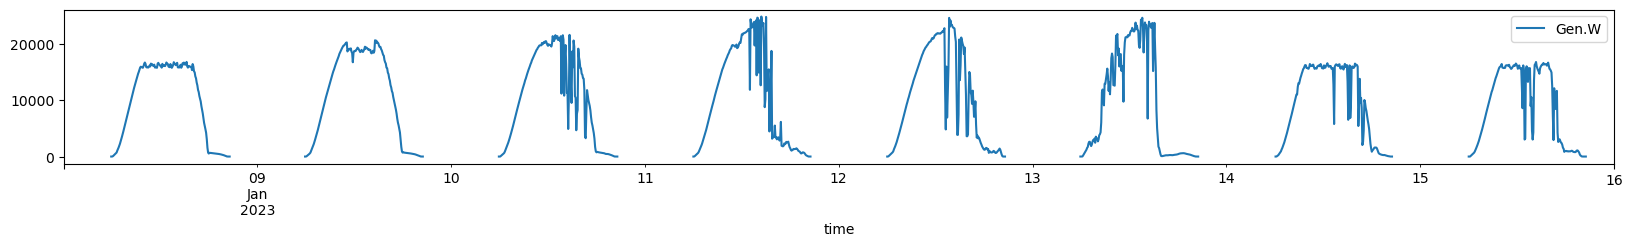

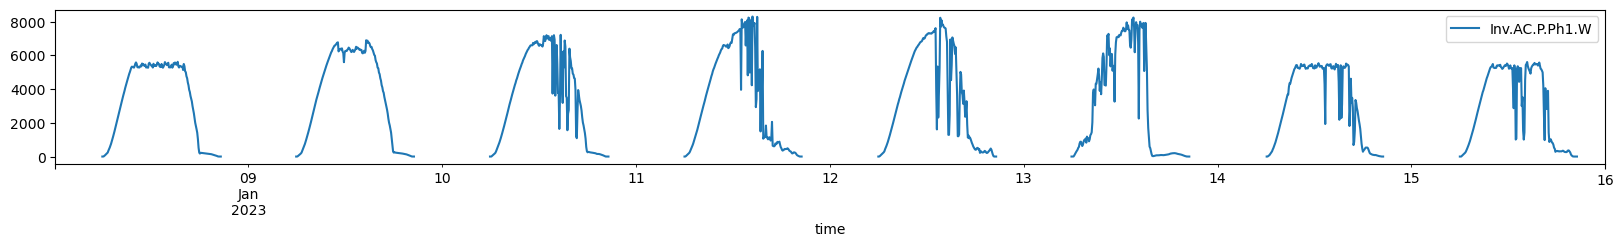

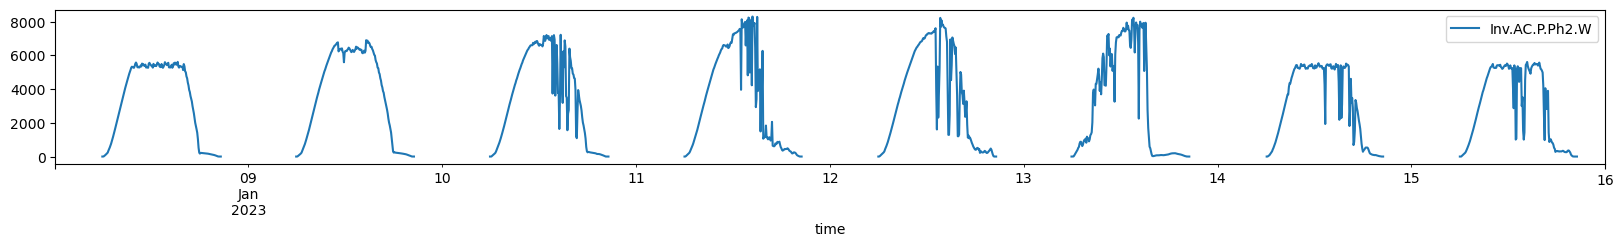

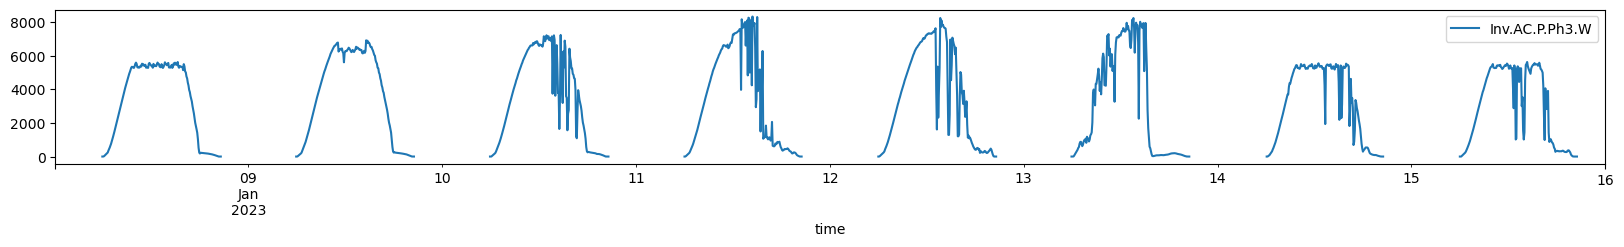

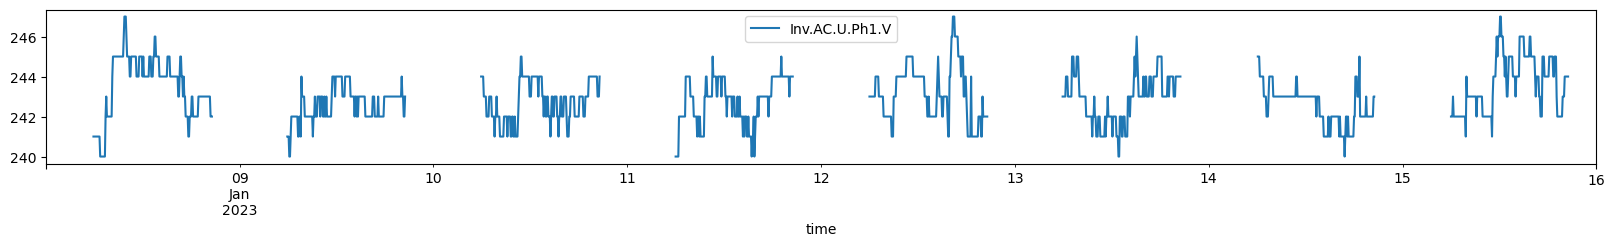

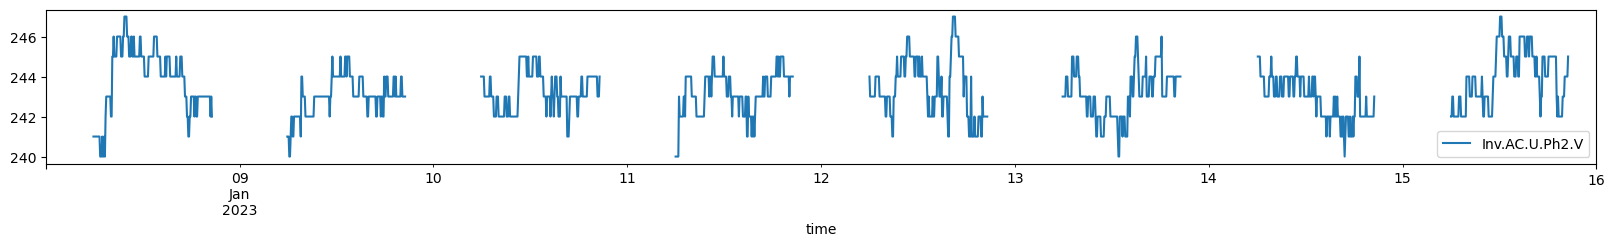

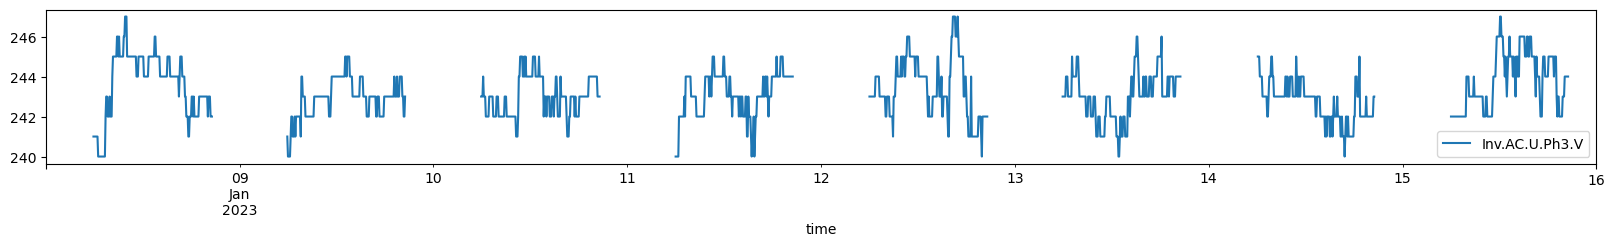

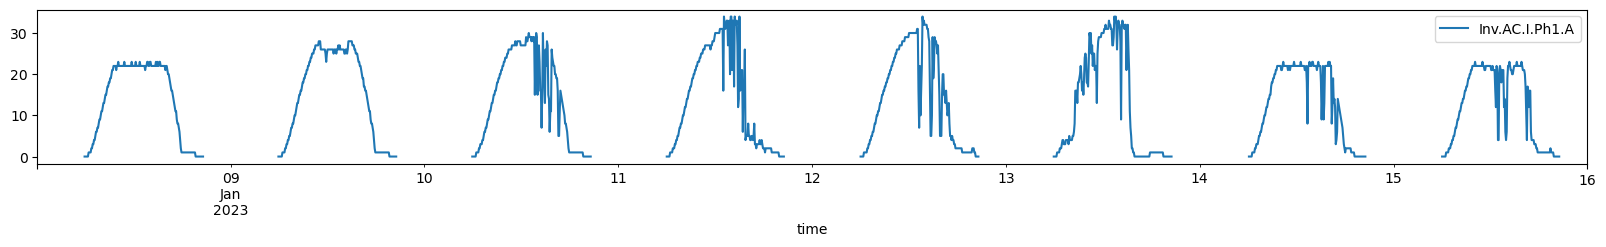

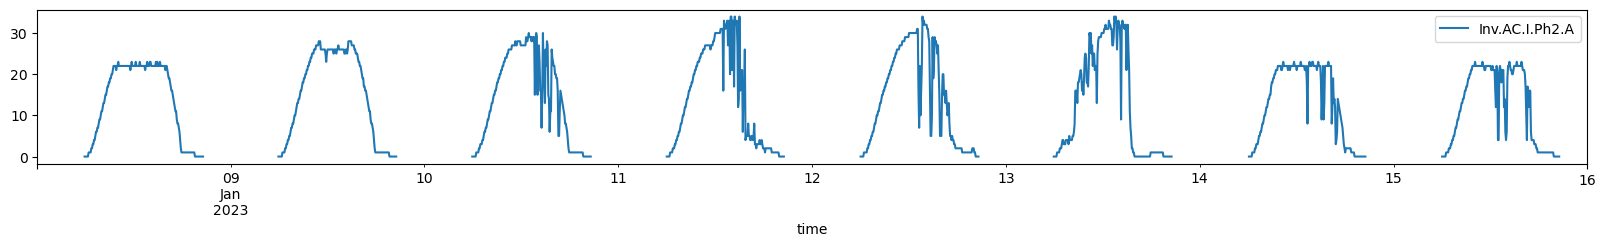

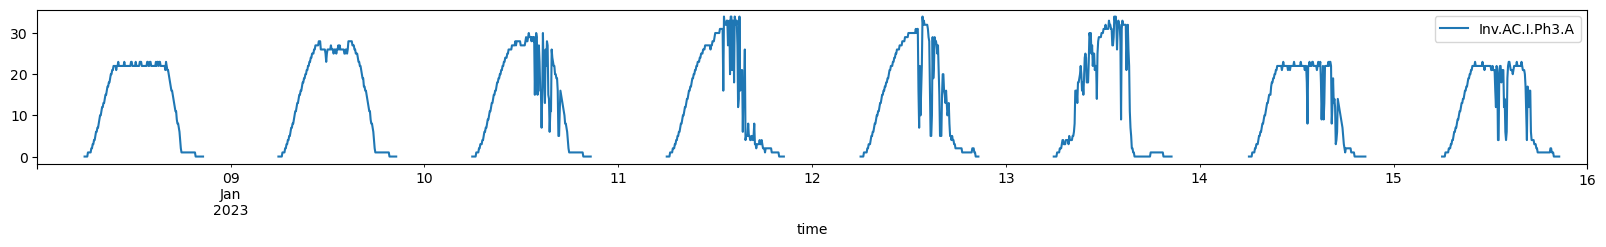

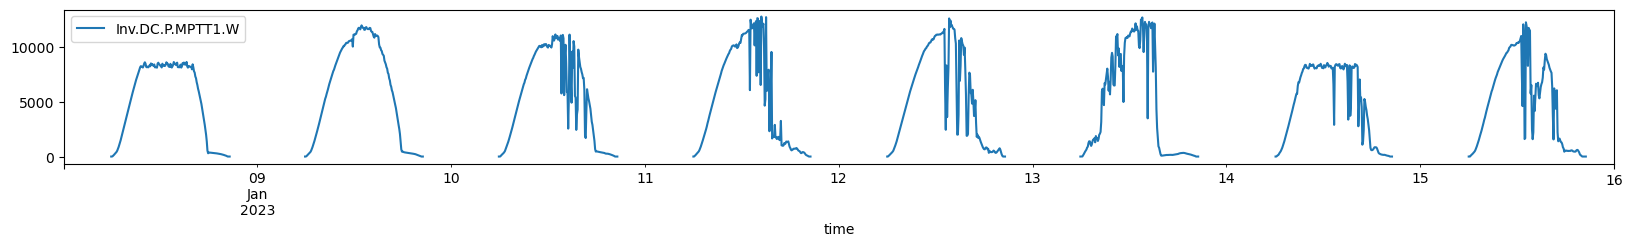

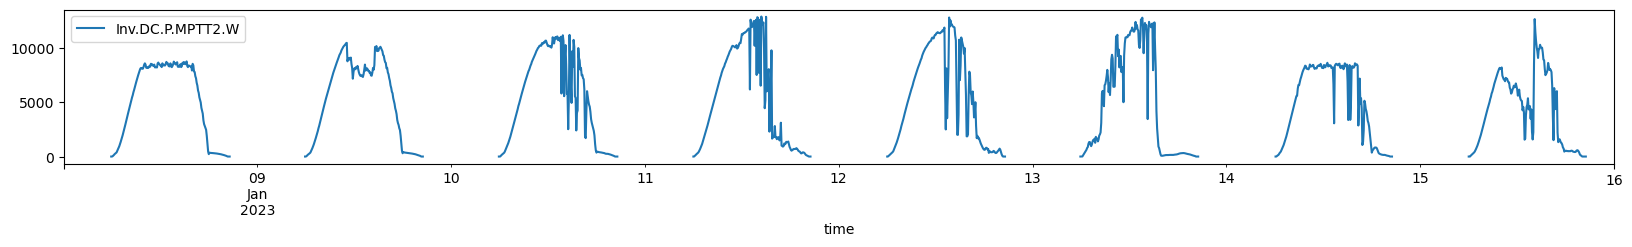

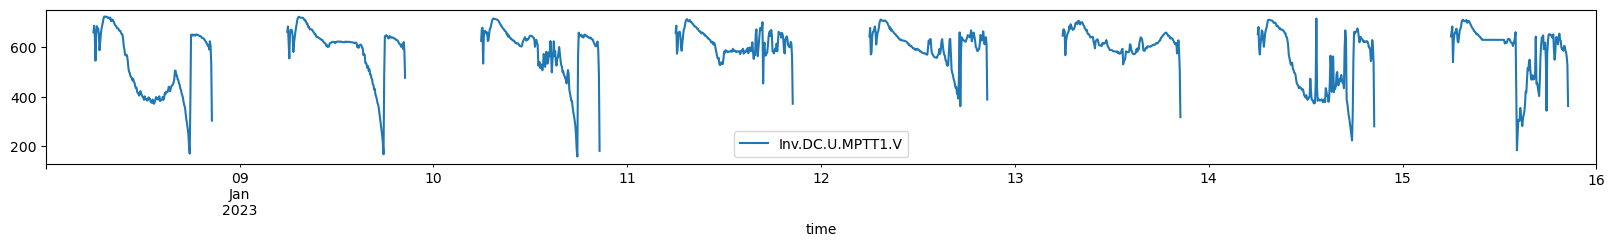

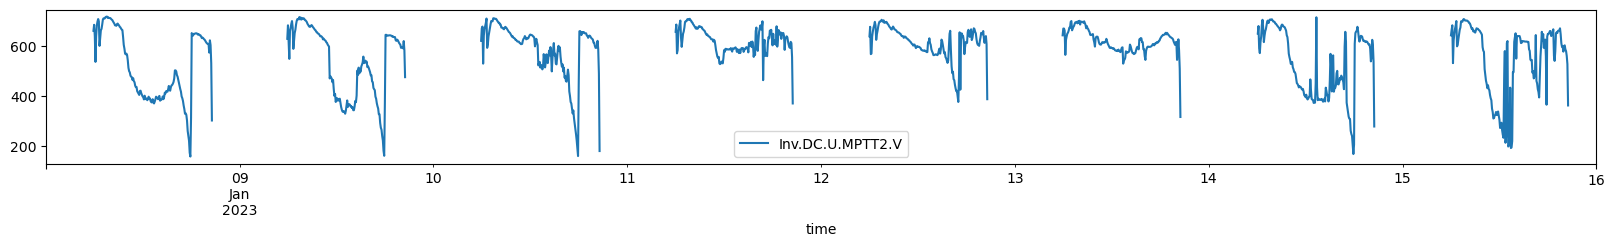

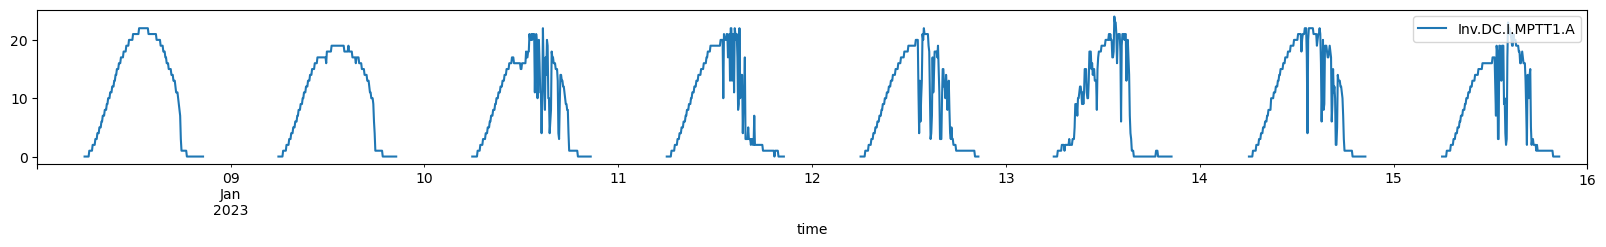

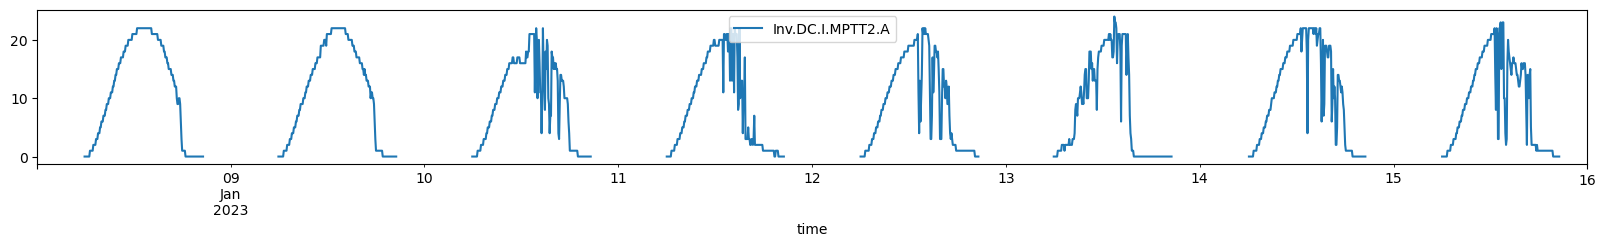

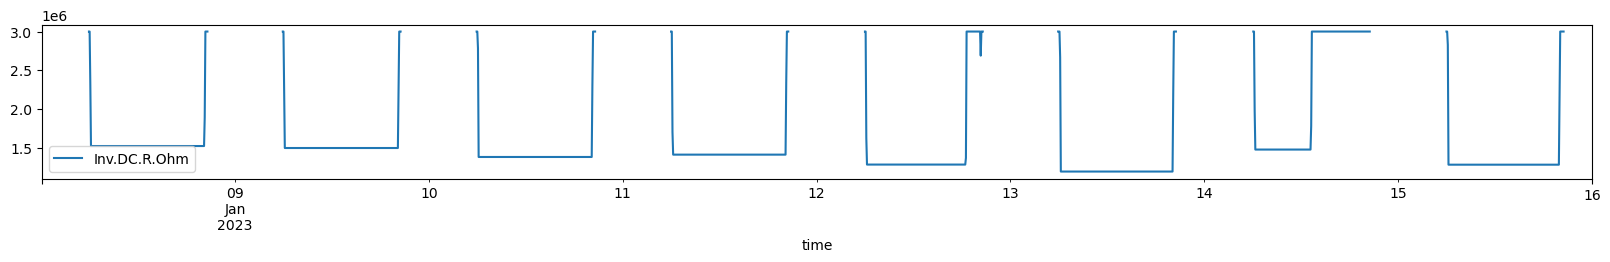

In [58]:
df_plot = df_raw[(df_raw['time']>'2023-01-08') & (df_raw['time']<='2023-01-16')].copy()
for icol in metrics_name_list:
    if len(df_plot[icol])>0:
        df_plot[['time', icol]].set_index('time').plot(figsize=(20, 2))

# 4 Preprocessing Data

In [59]:
# ========================================================
# = Select elements in a array or list with a string
# ========================================================
def select_elements_with_string(iterable, search_string):
    """
    Select elements from the iterable that include the search_string.

    Args:
        iterable (iterable): The input iterable (list, NumPy array, etc.).
        search_string (str): The string to search for.

    Returns:
        list or numpy.ndarray: Elements from the iterable that include the search_string.
    """
    if isinstance(iterable, list):
        return [item for item in iterable if search_string in item]
    elif isinstance(iterable, np.ndarray):
        mask = np.array([search_string in item for item in iterable])
        return iterable[mask]
    else:
        raise ValueError("Input iterable type not supported")

In [64]:
# ========================================================
# = Read raw data & preprocess data
# ========================================================

def read_preprocess_monitor(df_monitor, pvsize):
    '''
    MID: MNTR|6905111
    '''
    ## == read data for the single monotor
    df_monitor['time'] = pd.to_datetime(df_monitor['time'].values)
    ## some columns related with the time
    metrics_name_list = df_monitor.columns.to_list()[1:]
    power_metrics_list = select_elements_with_string(iterable=metrics_name_list, search_string='.W')
    df_monitor['minute'] = df_monitor['time'].dt.minute
    df_monitor['hour'] = df_monitor['time'].dt.hour
    df_monitor['date'] = df_monitor['time'].dt.date
    df_monitor['date'] = df_monitor['date'].astype(pd.StringDtype())

    ## == processing data ====##
    # ========================================================
    # = Processing outliers based on the PV size
    # ========================================================
    print(power_metrics_list)
    if len(power_metrics_list) != 0:
        df_pre = df_monitor.copy()
        # outliers
        for power_metric in power_metrics_list:
            df_pre.loc[df_pre[power_metric]>1.2*pvsize, metrics_name_list] = np.NaN
        # ========================================================
        # = Filling up the missing data
        # ========================================================
        first_valid_idx = df_pre['Gen.W'].first_valid_index()
        last_valid_idx = df_pre['Gen.W'].last_valid_index()
        df_pre = df_pre.iloc[first_valid_idx: last_valid_idx+1, :]
        df_pre.fillna(method='ffill', inplace=True)
        return df_pre
    else:
        return None

In [68]:
preprocess_results = read_preprocess_monitor(df_monitor=df_raw, pvsize=pv_size)
if preprocess_results is not None:
    df_pre=preprocess_results
else:
    print('There is no concern data')
df_pre.head()

['Gen.W', 'Inv.AC.P.Ph1.W', 'Inv.AC.P.Ph2.W', 'Inv.AC.P.Ph3.W', 'Inv.DC.P.MPTT1.W', 'Inv.DC.P.MPTT2.W']


,time,Gen.W,Inv.AC.P.Ph1.W,Inv.AC.P.Ph2.W,Inv.AC.P.Ph3.W,Inv.AC.U.Ph1.V,Inv.AC.U.Ph2.V,Inv.AC.U.Ph3.V,Inv.AC.I.Ph1.A,Inv.AC.I.Ph2.A,...,Inv.DC.P.MPTT1.W,Inv.DC.P.MPTT2.W,Inv.DC.U.MPTT1.V,Inv.DC.U.MPTT2.V,Inv.DC.I.MPTT1.A,Inv.DC.I.MPTT2.A,Inv.DC.R.Ohm,minute,hour,date
120,2022-09-06 10:00:00,15539.0,5177.0,5172.0,5191.0,244.0,245.0,245.0,21.0,21.0,...,7880.0,7976.0,682.0,669.0,12.0,12.0,2105402.0,0.0,10.0,2022-09-06
121,2022-09-06 10:05:00,15789.0,5259.0,5255.0,5276.0,244.0,244.0,245.0,22.0,22.0,...,8016.0,8094.0,679.0,667.0,12.0,12.0,2105402.0,5.0,10.0,2022-09-06
122,2022-09-06 10:10:00,16195.0,5395.0,5389.0,5411.0,244.0,244.0,244.0,22.0,22.0,...,8241.0,8322.0,680.0,666.0,12.0,13.0,2105402.0,10.0,10.0,2022-09-06
123,2022-09-06 10:15:00,16504.0,5496.0,5493.0,5514.0,244.0,245.0,245.0,22.0,22.0,...,8329.0,8473.0,675.0,669.0,12.0,13.0,2105402.0,15.0,10.0,2022-09-06
124,2022-09-06 10:20:00,16474.0,5488.0,5483.0,5503.0,244.0,244.0,245.0,22.0,22.0,...,8330.0,8467.0,673.0,667.0,12.0,13.0,2105402.0,20.0,10.0,2022-09-06


# 5 Identify the significant difference between different MPPTs

In [69]:
import itertools

In [70]:
Uthreshold_diff = 0.2
Ithreshold_diff = 0.2
Pthreshold_diff = 0.1
time_threshold = 3
mppt_power_list = df_raw.filter(regex='(?=.*MPTT)(?=.*W)').columns.to_list()
mppt_power_list

['Inv.DC.P.MPTT1.W', 'Inv.DC.P.MPTT2.W']

## 5.1. Comparison

In [71]:
def consecutive_compare(df, threshold_value, diff_name, thred_time):
    df['potential_'+diff_name] = df[diff_name]>threshold_value
    df['period'] = df['potential_'+diff_name].diff().ne(0).cumsum()
    df['duration'] = df.groupby('period')['potential_'+diff_name].transform('sum')
    df[diff_name+'_significant'] = df['potential_'+diff_name] & (df['duration']>=thred_time)
    df.drop(['potential_'+diff_name, 'period', 'duration'], axis=1, inplace=True)
    return df

In [74]:
# ========================================================
# = Comparison between different phases and MPPTs
# ========================================================
def combination_compare(df, Uthreshold_value, Ithreshold_value, Pthreshold_value, DC_AC, thred_time, metrics_name_list):
    '''
    df: df
    Uthreshold_value, Ithreshold_value, Pthreshold_value: threshold values for different metrics
    DC_AC: "AC" or "DC"
    thred_time:
    mppt_power_list: calculate the MPPT number
    '''
    for metric, metric_per in [['P', 'W'], ['U', 'V'], ['I', 'A']]:
        if metric =='U':
            threshold_value = Uthreshold_value
        elif metric == 'I':
            threshold_value = Ithreshold_value
        else:
            threshold_value = Pthreshold_value
        # different phase
        if DC_AC == 'AC':
            metrics_list = select_elements_with_string(iterable=metrics_name_list, search_string='Inv.AC.{}.Ph'.format(metric))
            compare_metric = 'AC.{}{}.Ph'.format(metric, metric_per)
            comblen = len(metrics_list)
        else:
            metrics_list = select_elements_with_string(iterable=metrics_name_list, search_string='Inv.DC.{}.MPTT'.format(metric))
            compare_metric = 'DC.{}{}.MPPT'.format(metric, metric_per)
            comblen = len(metrics_list)
        if comblen >= 2:
            maxvalue_list = []
            for j in metrics_list:
                maxvalue_list.append(df[j].max())
            # print(maxvalue)
            combinations = list(itertools.combinations(np.arange(comblen), 2))
            # print(combinations)
            diff_name_list = []
            for comb in combinations:
                metric1 = metrics_list[comb[0]]
                metric2 = metrics_list[comb[1]]
                maxvalue1 = maxvalue_list[comb[0]]
                maxvalue2 = maxvalue_list[comb[1]]
                diff_name = '{}({} vs {})_diff'.format(compare_metric, comb[0]+1, comb[1]+1)
                diff_name_list.append(diff_name+'_significant')
                df[diff_name] = (df[metric1]/maxvalue1 - df[metric2]/maxvalue2).abs()
                df = consecutive_compare(df=df, threshold_value=threshold_value, diff_name=diff_name, thred_time=thred_time)
            df[compare_metric+'_significant'] = False
            for diff_name_sig in diff_name_list:
                df[compare_metric+'_significant'] = df[compare_metric+'_significant']|df[diff_name_sig]
    return df

In [77]:
# ========================================================
# = Comparison between different phases and MPPTs
# ========================================================
def compare_diff(df, Uthreshold_value, Ithreshold_value, Pthreshold_value, thred_time, metrics_name_list):
    for adc_id in ['AC', 'DC']: 
        df = combination_compare(df=df, Uthreshold_value=Uthreshold_value, Ithreshold_value=Ithreshold_value,  
                                 Pthreshold_value=Pthreshold_value, DC_AC=adc_id, thred_time=thred_time, metrics_name_list=metrics_name_list)
    return df 
df_compare = df_pre.copy()
df_compare = compare_diff(df=df_compare, Uthreshold_value=Uthreshold_diff, Ithreshold_value=Ithreshold_diff, Pthreshold_value=Pthreshold_diff, thred_time=time_threshold, metrics_name_list=metrics_name_list)
df_compare                         

,time,Gen.W,Inv.AC.P.Ph1.W,Inv.AC.P.Ph2.W,Inv.AC.P.Ph3.W,Inv.AC.U.Ph1.V,Inv.AC.U.Ph2.V,Inv.AC.U.Ph3.V,Inv.AC.I.Ph1.A,Inv.AC.I.Ph2.A,...,AC.IA.Ph_significant,DC.PW.MPPT(1 vs 2)_diff,DC.PW.MPPT(1 vs 2)_diff_significant,DC.PW.MPPT_significant,DC.UV.MPPT(1 vs 2)_diff,DC.UV.MPPT(1 vs 2)_diff_significant,DC.UV.MPPT_significant,DC.IA.MPPT(1 vs 2)_diff,DC.IA.MPPT(1 vs 2)_diff_significant,DC.IA.MPPT_significant
120,2022-09-06 10:00:00,15539.0,5177.0,5172.0,5191.0,244.0,245.0,245.0,21.0,21.0,...,False,0.030019,False,False,0.014291,False,False,0.000000,False,False
121,2022-09-06 10:05:00,15789.0,5259.0,5255.0,5276.0,244.0,244.0,245.0,22.0,22.0,...,False,0.031976,False,False,0.013033,False,False,0.000000,False,False
122,2022-09-06 10:10:00,16195.0,5395.0,5389.0,5411.0,244.0,244.0,244.0,22.0,22.0,...,False,0.032815,False,False,0.015565,False,False,0.035714,False,False
123,2022-09-06 10:15:00,16504.0,5496.0,5493.0,5514.0,244.0,245.0,245.0,22.0,22.0,...,False,0.028615,False,False,0.005441,False,False,0.035714,False,False
124,2022-09-06 10:20:00,16474.0,5488.0,5483.0,5503.0,244.0,244.0,245.0,22.0,22.0,...,False,0.029133,False,False,0.005448,False,False,0.035714,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75947,2023-05-27 16:55:00,0.0,0.0,0.0,0.0,240.0,239.0,240.0,0.0,0.0,...,False,0.000000,False,False,0.003331,False,False,0.000000,False,False
75948,2023-05-27 17:00:00,0.0,0.0,0.0,0.0,239.0,239.0,239.0,0.0,0.0,...,False,0.000000,False,False,0.002013,False,False,0.000000,False,False
75949,2023-05-27 17:05:00,0.0,0.0,0.0,0.0,240.0,240.0,240.0,0.0,0.0,...,False,0.000000,False,False,0.001888,False,False,0.000000,False,False
75950,2023-05-27 17:10:00,0.0,0.0,0.0,0.0,239.0,239.0,240.0,0.0,0.0,...,False,0.000000,False,False,0.002892,False,False,0.000000,False,False


In [78]:
filter_df = df_compare.filter(regex='_significant')
comapre_columns_list = filter_df.columns.to_list()
filter_df['time'] = df_compare['time'].values
filter_df['date'] = filter_df['time'].dt.date.astype(str)
df_sig = filter_df[filter_df[comapre_columns_list].any(axis=1)]
df_sig


,AC.PW.Ph(1 vs 2)_diff_significant,AC.PW.Ph(1 vs 3)_diff_significant,AC.PW.Ph(2 vs 3)_diff_significant,AC.PW.Ph_significant,AC.UV.Ph(1 vs 2)_diff_significant,AC.UV.Ph(1 vs 3)_diff_significant,AC.UV.Ph(2 vs 3)_diff_significant,AC.UV.Ph_significant,AC.IA.Ph(1 vs 2)_diff_significant,AC.IA.Ph(1 vs 3)_diff_significant,AC.IA.Ph(2 vs 3)_diff_significant,AC.IA.Ph_significant,DC.PW.MPPT(1 vs 2)_diff_significant,DC.PW.MPPT_significant,DC.UV.MPPT(1 vs 2)_diff_significant,DC.UV.MPPT_significant,DC.IA.MPPT(1 vs 2)_diff_significant,DC.IA.MPPT_significant,time,date
3937,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2022-09-19 16:05:00,2022-09-19
3938,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2022-09-19 16:10:00,2022-09-19
3939,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2022-09-19 16:15:00,2022-09-19
5666,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2022-09-25 16:10:00,2022-09-25
5667,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2022-09-25 16:15:00,2022-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69604,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2023-05-05 16:20:00,2023-05-05
69605,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2023-05-05 16:25:00,2023-05-05
70757,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2023-05-09 16:25:00,2023-05-09
70758,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,2023-05-09 16:30:00,2023-05-09


In [79]:
df_pw = df_compare.filter(regex='_significant').filter(regex='PW.')
comapre_columns_pw_list = df_pw.columns.to_list()
df_pw['time'] = df_compare['time'].values
df_pw['date'] = df_pw['time'].dt.date.astype(str)
df_pw_sig = df_pw[df_pw[comapre_columns_pw_list].any(axis=1)]
df_pw_sig


,AC.PW.Ph(1 vs 2)_diff_significant,AC.PW.Ph(1 vs 3)_diff_significant,AC.PW.Ph(2 vs 3)_diff_significant,AC.PW.Ph_significant,DC.PW.MPPT(1 vs 2)_diff_significant,DC.PW.MPPT_significant,time,date
31797,False,False,False,False,True,True,2022-12-25 09:45:00,2022-12-25
31798,False,False,False,False,True,True,2022-12-25 09:50:00,2022-12-25
31799,False,False,False,False,True,True,2022-12-25 09:55:00,2022-12-25
31800,False,False,False,False,True,True,2022-12-25 10:00:00,2022-12-25
31801,False,False,False,False,True,True,2022-12-25 10:05:00,2022-12-25
...,...,...,...,...,...,...,...,...
54034,False,False,False,False,True,True,2023-03-12 14:50:00,2023-03-12
54035,False,False,False,False,True,True,2023-03-12 14:55:00,2023-03-12
54037,False,False,False,False,True,True,2023-03-12 15:05:00,2023-03-12
54038,False,False,False,False,True,True,2023-03-12 15:10:00,2023-03-12


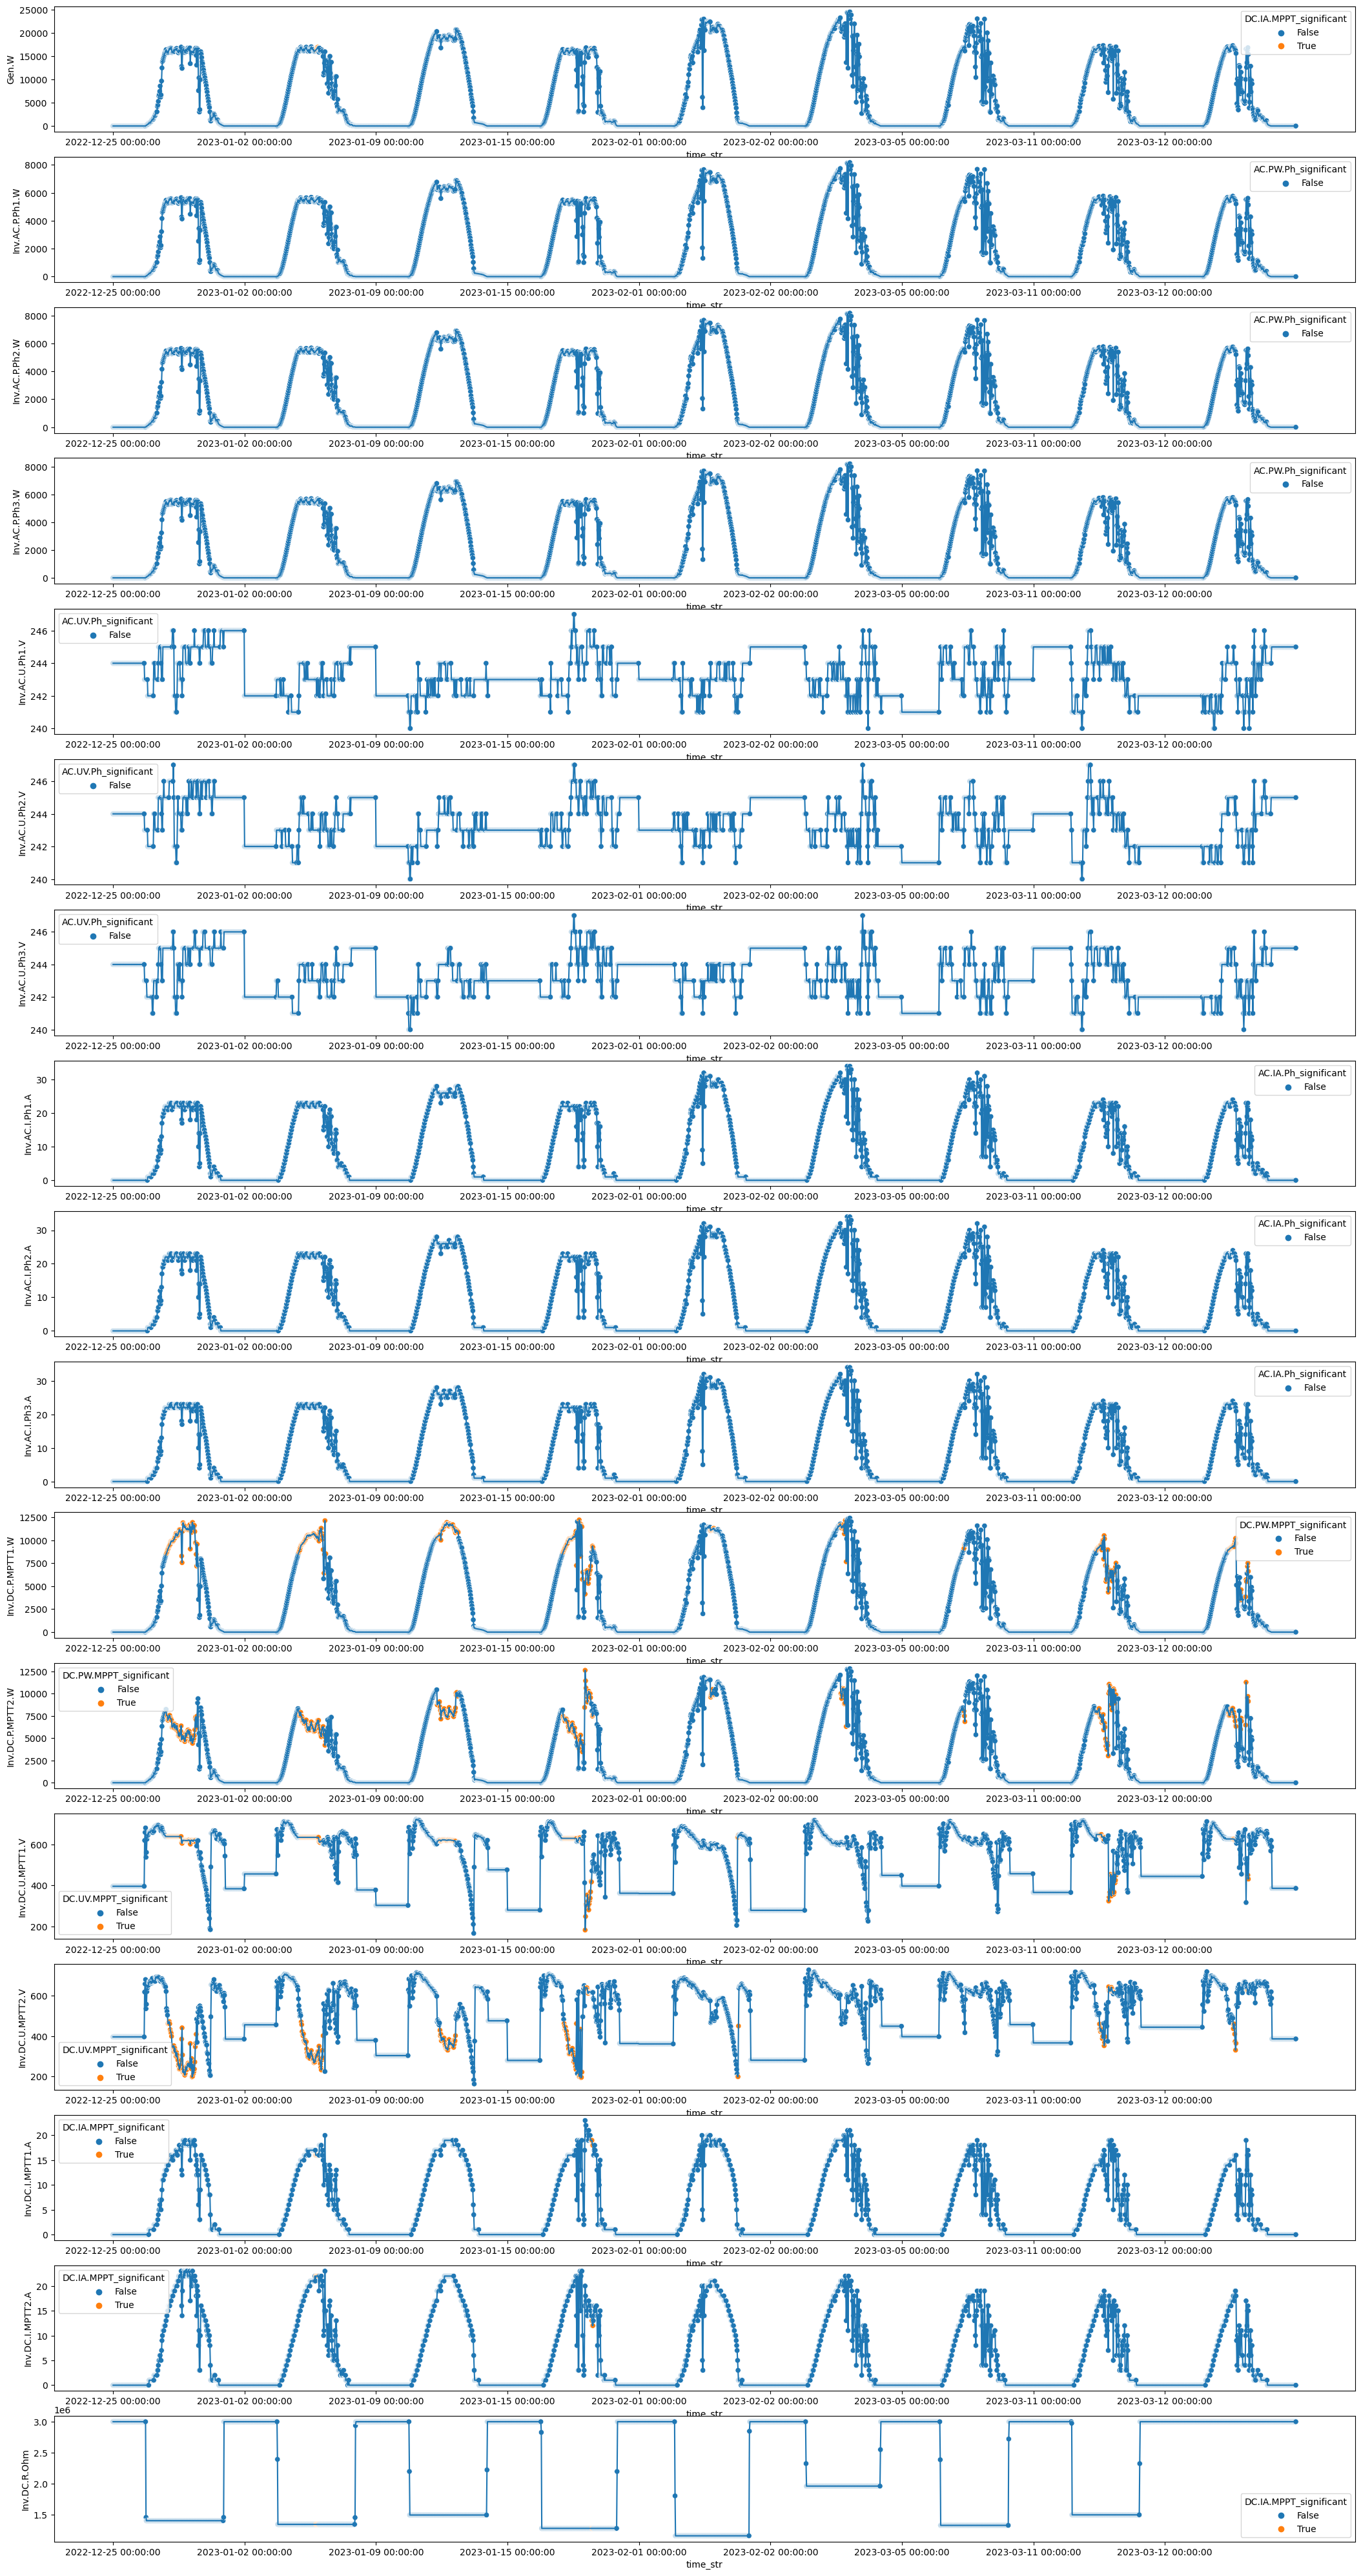

In [84]:
# plot
fig, axes = plt.subplots(nrows=len(metrics_name_list), figsize=(26, 3*len(metrics_name_list)))
date_significant_list = df_pw_sig['date'].unique()
df_plot_sig = df_compare[df_compare['date'].isin(date_significant_list)].copy()
df_plot_sig['time_str'] = df_plot_sig['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
for i, icol in enumerate(metrics_name_list):
    if 'AC.' in icol:
        if 'P.' in icol:
            compare_metric = 'AC.PW.Ph_significant'
        elif 'U.' in icol:
            compare_metric = 'AC.UV.Ph_significant'
        else:
            compare_metric = 'AC.IA.Ph_significant'
    else:
        if 'P.' in icol:
            compare_metric = 'DC.PW.MPPT_significant'
        elif 'U.' in icol:
            compare_metric = 'DC.UV.MPPT_significant'
        else:
            compare_metric = 'DC.IA.MPPT_significant'
    sns.lineplot(data=df_plot_sig, x ='time_str', y=icol, ax=axes[i])
    sns.scatterplot(data=df_plot_sig, x='time_str', y=icol, hue=compare_metric, ax=axes[i])
    axes[i].set_xticks(axes[i].get_xticks()[::288])

0
2


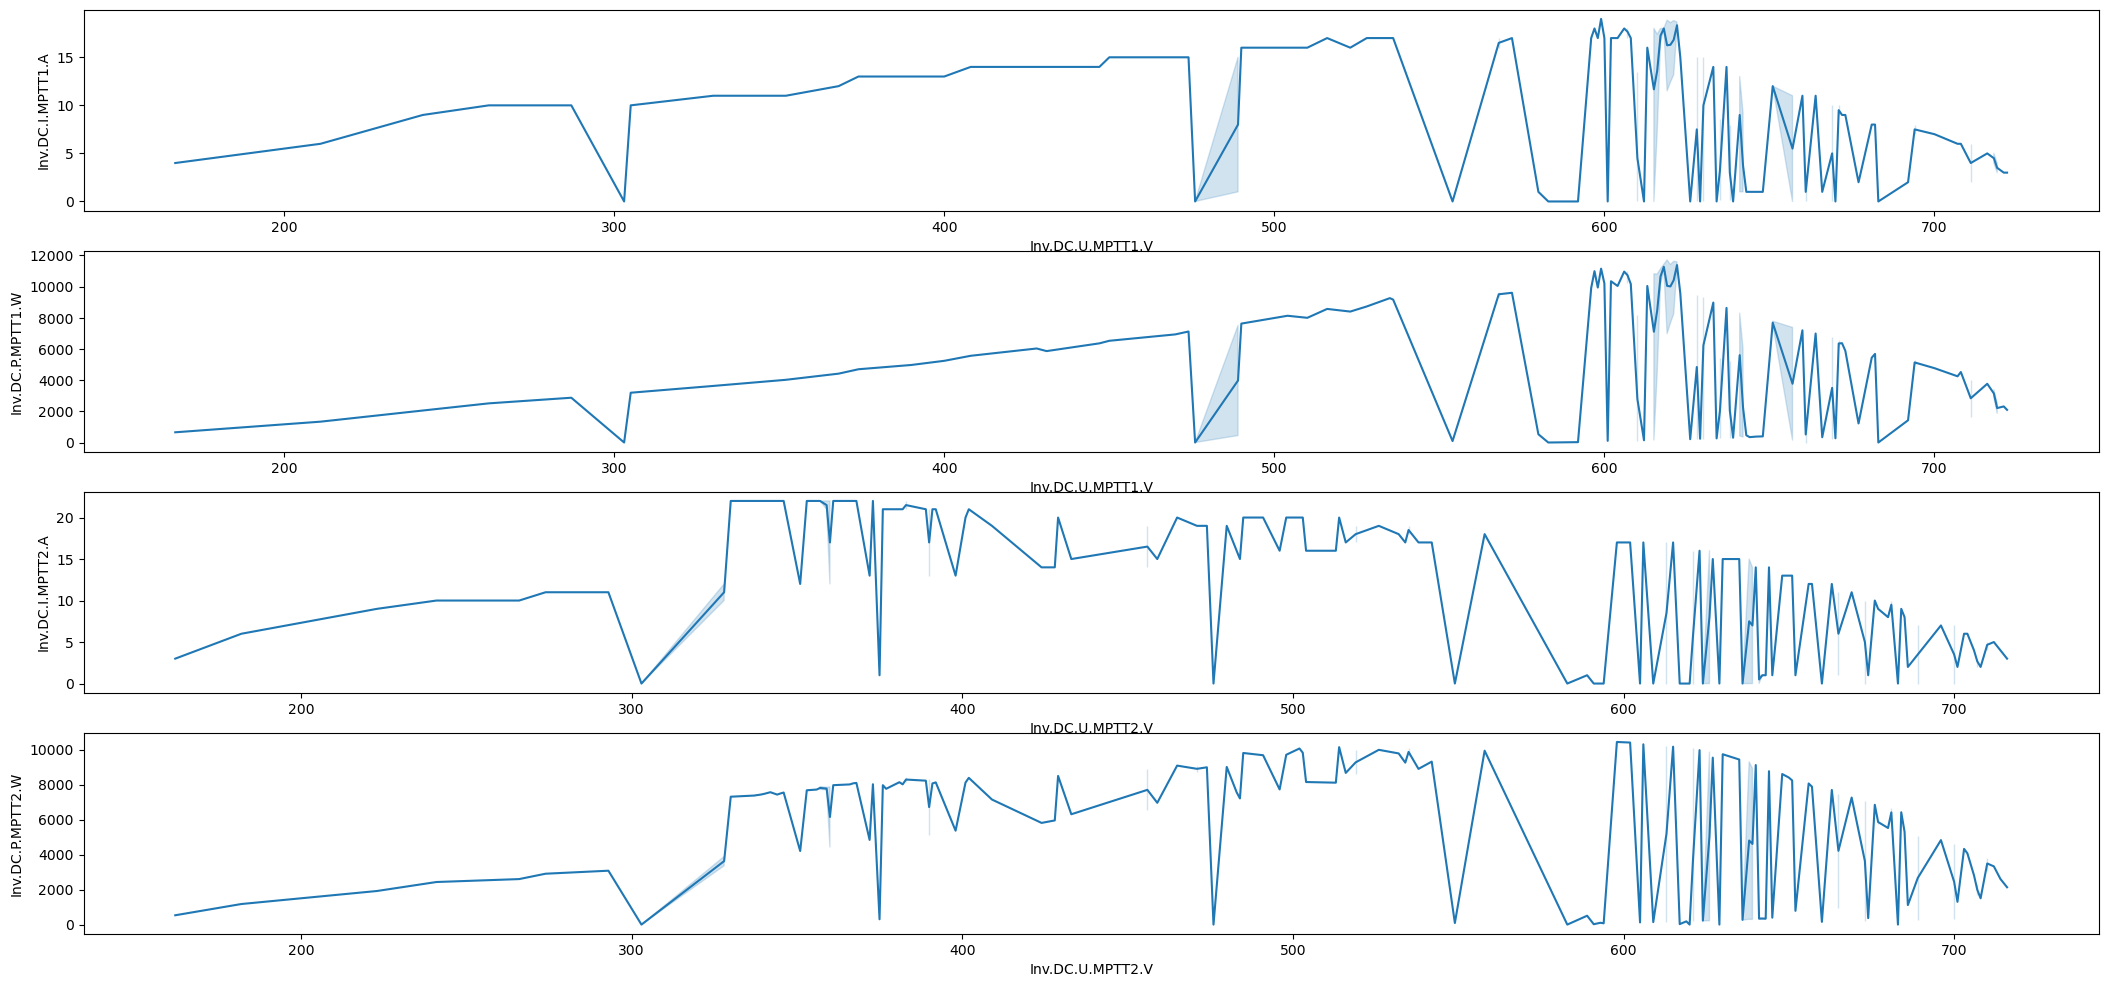

In [83]:
# plot I-V curve
fig, axes = plt.subplots(nrows=len(mppt_power_list)*2, figsize=(26, 3*len(mppt_power_list)*2))
for mppt_id in np.arange(len(mppt_power_list)):
    ax_start = 2*mppt_id
    print(ax_start)
    sns.lineplot(df_plot_sig[df_plot_sig['date']=='2023-01-09'], x='Inv.DC.U.MPTT{}.V'.format(mppt_id+1), y='Inv.DC.I.MPTT{}.A'.format(mppt_id+1), ax=axes[ax_start])
    sns.lineplot(df_plot_sig[df_plot_sig['date']=='2023-01-09'], x='Inv.DC.U.MPTT{}.V'.format(mppt_id+1), y='Inv.DC.P.MPTT{}.W'.format(mppt_id+1), ax=axes[ax_start+1])
    